In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

df_eddies = pd.read_pickle('/srv/scratch/z5297792/Chapter2/SEACOFS_26yr_Eddy_Dataset/Eddy_Data/df_eddies_processed_1462_10650.pkl')
df_eddies_old = pd.read_pickle('/srv/scratch/z5297792/Chapter2/SEACOFS_26yr_Eddy_Dataset/Eddy_Data/df_eddies_processed_1462_10650_old.pkl')


In [2]:
sample_eddies_old = [474, 971, 1917, 1978, 33, 207, 1783, 2370]


425
871
nan
1780
31
182
1602
2128


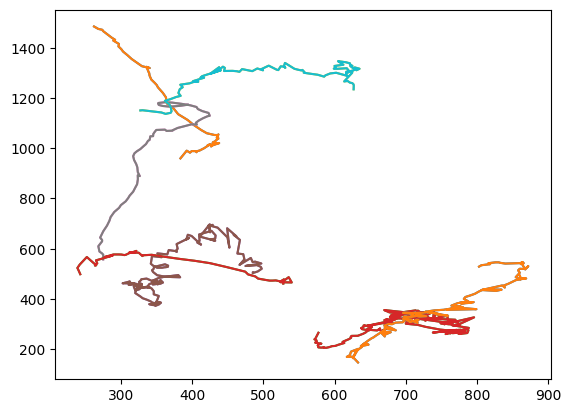

In [3]:
for eddy in sample_eddies_old:

    df_eddy_old = df_eddies_old[df_eddies_old.Eddy==eddy]
    
    eddy_days = df_eddies_old[df_eddies_old.Eddy==eddy].Day.unique()
    df = df_eddies[df_eddies.Day.isin(eddy_days)]
    
    # total number of unique days in the dataset
    total_days = df['Day'].nunique()
    
    # find eddies that appear in all days
    eddies_all_days = (
        df.groupby('Eddy')['Day'].nunique()
          .loc[lambda x: x == total_days]
          .index.tolist()
    )
    
    # print(eddies_all_days)
    
    R = []
    for eddy_new in eddies_all_days:
    
        df_eddy = df_eddies[df_eddies.Eddy==eddy_new]
        if len(df_eddy) == len(df_eddy_old):
        
            R.append(np.sum(np.hypot(df_eddy.xc.values - df_eddy_old.xc.values, df_eddy.yc.values - df_eddy_old.yc.values)))
    
        else:
            R.append(np.inf)
    
    if len(R):
        R = np.array(R)
        eddy_new = eddies_all_days[np.argmin(R)]
        df_eddy = df_eddies[df_eddies.Eddy==eddy_new]
        
        print(eddy_new)
        
        plt.plot(df_eddy.xc, df_eddy.yc)
        plt.plot(df_eddy_old.xc, df_eddy_old.yc)
    else:
        print(np.nan)


In [4]:
sample_eddies = [425, 871, np.nan, 1780, 31, 182, 1602, 2128] # 66 to replace nan


In [5]:
import netCDF4 as nc
from scipy.interpolate import griddata
import netCDF4 as nc
from scipy.interpolate import RegularGridInterpolator
import time

# Field Data

fname = f'/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'

dataset = nc.Dataset(fname)

lon_rho = np.transpose(dataset.variables['lon_rho'], axes=(1, 0))
lat_rho = np.transpose(dataset.variables['lat_rho'], axes=(1, 0))
mask_rho = np.transpose(dataset.variables['mask_rho'], axes=(1, 0))
h =  np.transpose(dataset.variables['h'], axes=(1, 0))
f =  np.transpose(dataset.variables['f'], axes=(1, 0))
angle = dataset.variables['angle'][0, 0]
z_r = np.load('/srv/scratch/z5297792/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))[150, 150, :]

def distance(lat1, lon1, lat2, lon2):
    EARTH_RADIUS = 6357
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return EARTH_RADIUS * 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

j_mid = lon_rho.shape[1] // 2
i_mid = lon_rho.shape[0] // 2

dx = distance(lat_rho[:-1, j_mid], lon_rho[:-1, j_mid],
              lat_rho[1:, j_mid], lon_rho[1:, j_mid])
dy = distance(lat_rho[i_mid, :-1], lon_rho[i_mid, :-1],
              lat_rho[i_mid, 1:], lon_rho[i_mid, 1:])

x_grid = np.insert(np.cumsum(dx), 0, 0)
y_grid = np.insert(np.cumsum(dy), 0, 0)
X_grid, Y_grid = np.meshgrid(x_grid, y_grid, indexing='ij')


In [15]:
df_eddy_old = df_eddies_old[df_eddies_old.Eddy==1917]
df_eddy_old.head()


,Eddy,Day,Cyc,Lon,Lat,ic,jc,xc,yc,w,Q11,Q12,Q22,Rc,psi0,Age,Date,fname
76404,1917,7451,AE,159.399815,-27.609375,222,308,705.063375,1524.453501,0.000013,0.002673,0.001667,0.003846,52.750949,-999999.975766,56,2010-05-27,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
76405,1917,7452,AE,159.558569,-27.954881,227,302,731.163185,1493.441469,0.000016,0.004505,0.000917,0.003421,69.500703,-21.947495,56,2010-05-28,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
76406,1917,7453,AE,159.663219,-28.092048,229,300,745.395728,1482.526306,0.000015,0.004618,0.000063,0.002854,73.251344,-18.239027,56,2010-05-29,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
76407,1917,7454,AE,159.662349,-28.079616,229,300,744.915699,1483.807649,0.000014,0.004998,0.000331,0.002220,47.500262,-16.402526,56,2010-05-30,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
76408,1917,7455,AE,159.681771,-28.128239,230,299,748.296213,1479.338218,0.000015,0.005090,0.000440,0.002364,50.751317,-14.639718,56,2010-05-31,/srv/scratch/z3533156/26year_BRAN2020/outer_av...


In [16]:
len(df_eddy_old)

56

In [46]:
eddies = df_eddies[(df_eddies.Age>=56)&(df_eddies.Cyc=='AE')&(df_eddies.xc>=700)&(df_eddies.yc>=1000)].Eddy.unique()
eddies 


array([  66,  224,  339,  407,  443,  488,  555,  602, 1268, 1298, 1323,
       1325, 1390, 1465, 1493, 1538, 1665, 1835, 1883, 2141, 2345, 2390,
       2583, 2616])

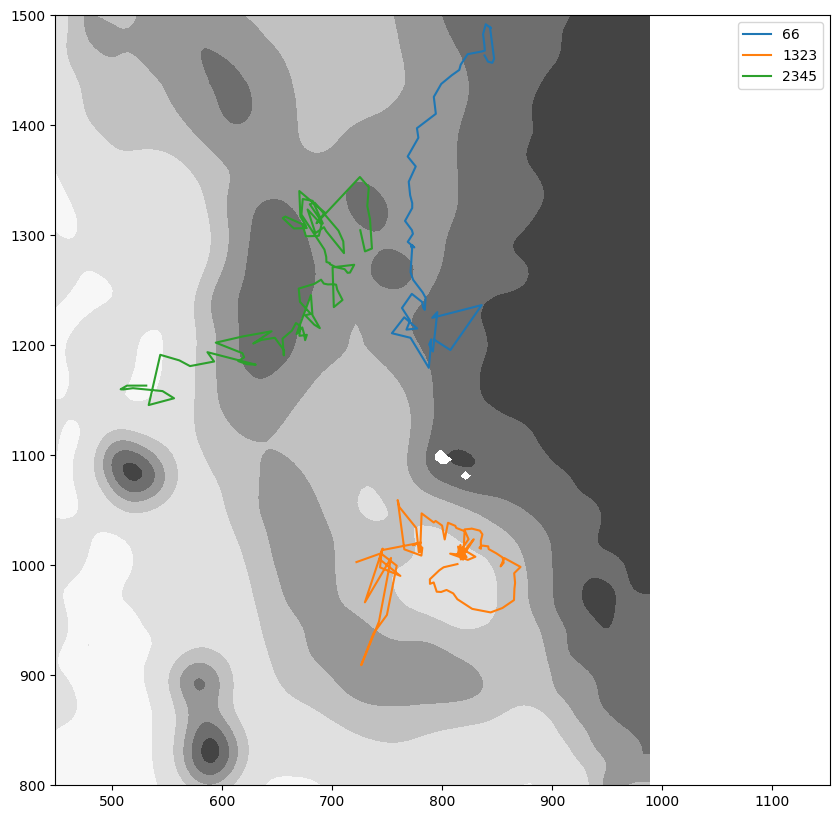

In [48]:
plt.figure(figsize=(10,10))
plt.contourf(X_grid, Y_grid, np.where(mask_rho, h, np.nan), cmap='Greys_r')
# plt.plot(df_eddy_old.xc, df_eddy_old.yc, c='r')

for eddy in eddies:
    if eddy in [66, 1323, 2345]:
        df_eddy = df_eddies[df_eddies.Eddy==eddy]
    
        plt.plot(df_eddy.xc, df_eddy.yc, label=eddy)
plt.axis('equal'); plt.legend()
plt.xlim(600, 1000); plt.ylim(800, 1500);
             